In [27]:
run_number         = 4520
input_file_pattern = "/Users/Gonzalo/github/NEXTdata/Na22/{}/rwf/*.h5".format(run_number)
output_file_name   = "/Users/Gonzalo/github/NEXTdata/evt_class_{}.h5" .format(run_number)

min_time = 450 # in mus
max_rms  = [15]*11

# Notebook configuration

In [28]:
import glob

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.database.load_db           as     db
from   invisible_cities.core    .system_of_units_c import units
import invisible_cities.reco    .tbl_functions     as     tbl

## Plotting options

In [29]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16, 12

# Initialization

In [40]:
rms_array    = []
evt_no_array = []
has_grass    = []

min_index = int(min_time * units.mus // (25 * units.ns))
active = db.DataPMT(run_number).Active.values.astype(bool)

max_rms = np.array(max_rms)

input_file_names = glob.glob(input_file_pattern)

# Classify events

In [41]:
for input_file_name in input_file_names[:2]:
    with tb.open_file(input_file_name, "r") as h5in:
        pmtrwf = tbl.get_rwf_vectors(h5in)[1].read()
        evt_nos, _            = tbl.get_event_numbers_and_timestamps_from_file(h5in)

        evt_no_array.extend(evt_nos.tolist())
        for evt, evt_no in enumerate(evt_nos):
            wf  = pmtrwf[evt, active, min_index:]
            rms = np.mean(np.std(wf, axis=1))
            rms_array.append(rms)
            has_grass.append(np.all(rms >= max_rms))

rms_array    = np.array(   rms_array)
evt_no_array = np.array(evt_no_array)
has_grass    = np.array(has_grass)

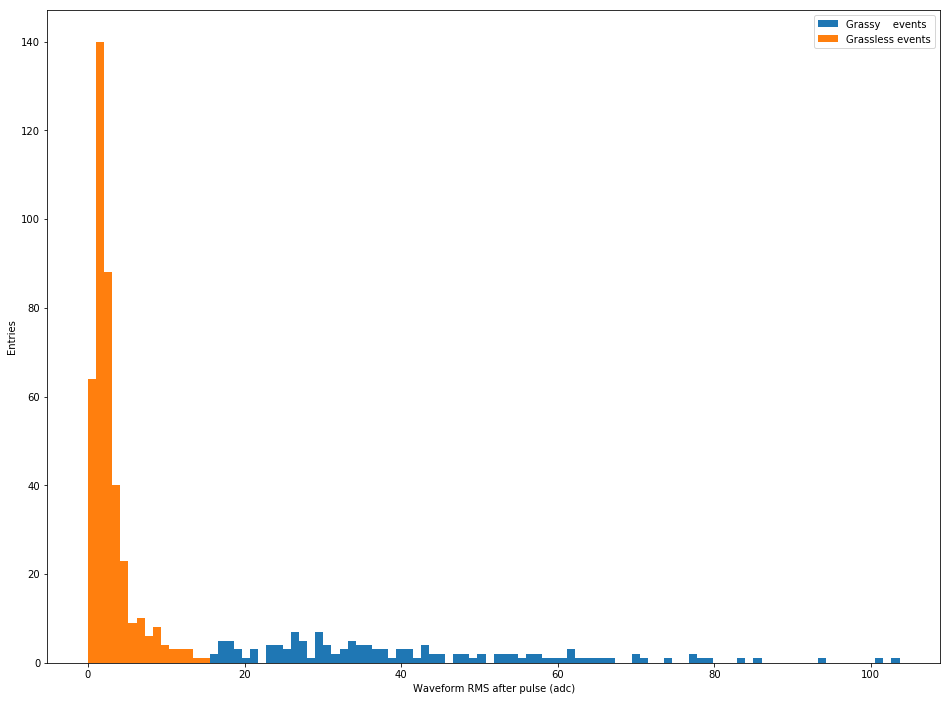

In [46]:
rms_bins = np.linspace(0, rms_array.max(), 101)
plt.hist(rms_array[ has_grass], rms_bins, label="Grassy    events")
plt.hist(rms_array[~has_grass], rms_bins, label="Grassless events")
plt.legend()
plt.xlabel("Waveform RMS after pulse (adc)")
plt.ylabel("Entries")

# Save events

In [ ]:
with tb.open_file(output_file_name, "w") as h5out:
    tb.create_array(h5in.root, "Grassless", evt_no_array[~has_grass], "Events without grass")
    tb.create_array(h5in.root, "Grassy"   , evt_no_array[ has_grass], "Events with grass")